In [63]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
#np.random.seed(42) # For reproducibilty

## Functions and Classes

In [65]:
class Bandit:
    """
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    """
    def __init__(self, k_arm=10, epsilon=0., initial=0., decay=2, step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0., change=False, epsilon_decay=False,decay_interval=200):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.decay_interval = decay_interval
        self.decay = decay
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.epsilon_decay = epsilon_decay
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        self.ogeps = epsilon
        self.change = change

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

        self.epsilon = self.ogeps

    # get an action for this bandit
    def act(self):

        if self.epsilon_decay:
            if self.time%self.decay_interval == 0:
                self.epsilon /= self.decay

        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # NewEstimate = OldEstimate + StepSize[Target . OldEstimate] where stepsize = 1/k where k is the number of times the action is called.
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            '''
            update estimation with constant step size , useful for non stationary problems  we often encounter reinforcement learning problems that are e↵ectively nonstationary. 
            In such cases it makes sense to give more weight to recent rewards than to long-past rewards. One of the most popular ways of doing this is to use a constant step-size parameter
            '''
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [66]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        av_best = 0
        for r in trange(runs):
            bandit.reset()
            av_best += bandit.q_true[bandit.best_action]
            
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1

                #if the time=t is at its half then we change the enviornment by giving differetn reward distributions to the action values.
                if bandit.change == True:
                    if t == time/2:
                        bandit.q_true = np.random.randn(bandit.k) + bandit.true_reward

    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards, av_best

# Non-stationary Enviornment

In [94]:
# Hyperparameters
runs = 2000
time = 1000

In [95]:
# Comparing various step-size values
bandits = []
bandits.append(Bandit(epsilon=0.01, sample_averages=True, change=True))
bandits.append(Bandit(epsilon=0.01, step_size=0.1, sample_averages=False, change=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=False, epsilon_decay=True, initial=5,step_size=0.1,change=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=False, epsilon_decay=True, initial=5,step_size=0.1,change=True,UCB_param=2))
bandits.append(Bandit(epsilon=0.01, sample_averages=False, epsilon_decay=False, initial=5,step_size=0.1,change=True,gradient=True,gradient_baseline=False))
bandits.append(Bandit(epsilon=0.01, sample_averages=False, epsilon_decay=False, initial=5,step_size=0.1,change=True,gradient=True,gradient_baseline=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=False, epsilon_decay=True, initial=5,step_size=0.1,change=True,gradient=True,gradient_baseline=True))
_, average_rewards, av_best = simulate(runs, time, bandits)

plt.figure(figsize=(20, 8), dpi= 440, facecolor='w', edgecolor='k')

100%|██████████| 2000/2000 [03:45<00:00,  8.88it/s]


<Figure size 8800x3520 with 0 Axes>

<Figure size 8800x3520 with 0 Axes>

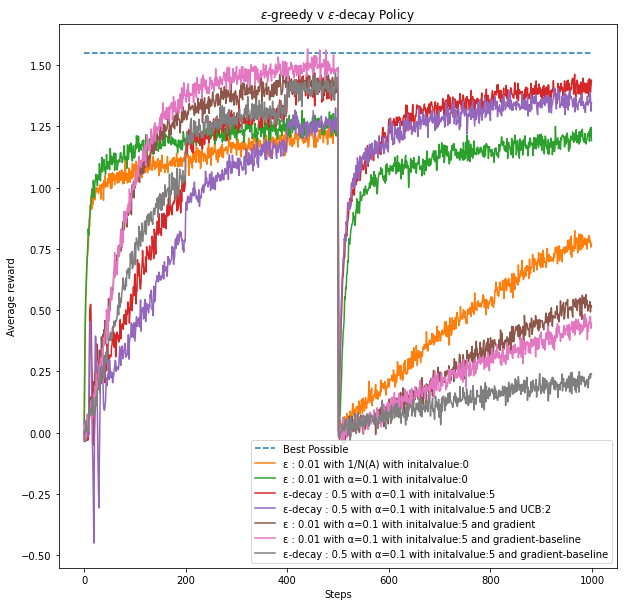

In [96]:
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot([av_best / runs for _ in range(time)], linestyle="--",label='Best Possible')
plt.plot(average_rewards[0], label='ε : 0.01 with 1/N(A) with initalvalue:0')
plt.plot(average_rewards[1], label='ε : 0.01 with α=0.1 with initalvalue:0')
plt.plot(average_rewards[2], label='ε-decay : 0.5 with α=0.1 with initalvalue:5')
plt.plot(average_rewards[3], label='ε-decay : 0.5 with α=0.1 with initalvalue:5 and UCB:2')
plt.plot(average_rewards[4], label='ε : 0.01 with α=0.1 with initalvalue:5 and gradient')
plt.plot(average_rewards[5], label='ε : 0.01 with α=0.1 with initalvalue:5 and gradient-baseline')
plt.plot(average_rewards[6], label='ε-decay : 0.5 with α=0.1 with initalvalue:5 and gradient-baseline')
plt.title("$\epsilon$-greedy v $\epsilon$-decay Policy")
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show() 

## Distribution

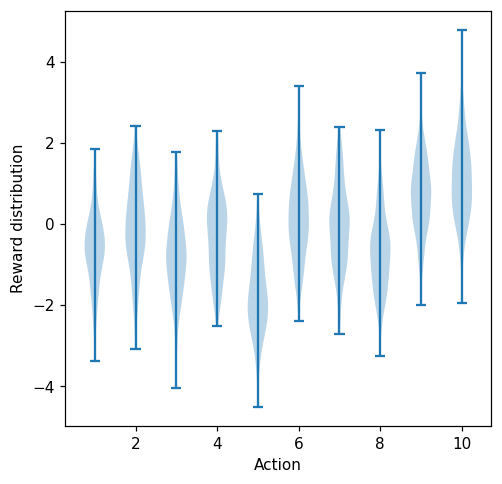

In [ ]:
np.random.seed(42) 
plt.figure(figsize=(5, 5), dpi= 110, facecolor='w', edgecolor='k')
plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()

# Epsilon Methods

## Greedy, epsilon and decay

In [ ]:
# Hyperparameters
runs = 2000
time = 1000

In [ ]:
# Epsilon decay Policy
bandits = []
bandits.append(Bandit(epsilon=0, sample_averages=True))
bandits.append(Bandit(epsilon=0.01, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True, epsilon_decay=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=True, epsilon_decay=True))
_, average_rewards, av_best = simulate(runs, time, bandits)



100%|██████████| 2000/2000 [01:38<00:00, 20.40it/s]


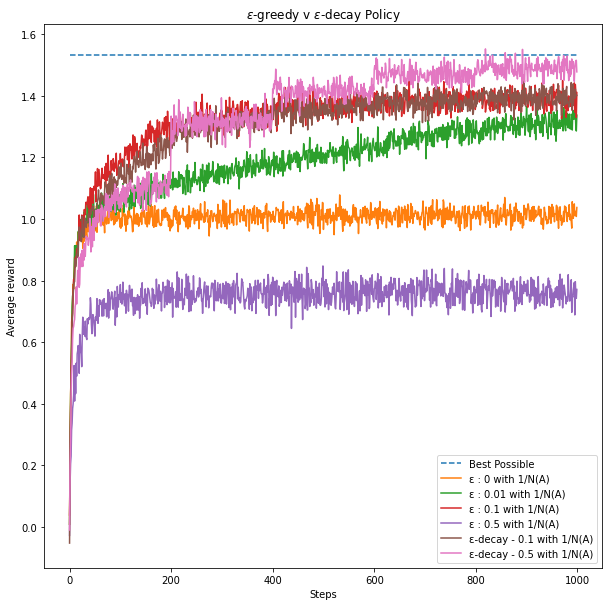

In [ ]:
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot([av_best / runs for _ in range(time)], linestyle="--",label='Best Possible')
plt.plot(average_rewards[0], label='ε : 0 with 1/N(A)')
plt.plot(average_rewards[1], label='ε : 0.01 with 1/N(A)')
plt.plot(average_rewards[2], label='ε : 0.1 with 1/N(A)')
plt.plot(average_rewards[3], label='ε : 0.5 with 1/N(A)')
plt.plot(average_rewards[4], label='ε-decay - 0.1 with 1/N(A)')
plt.plot(average_rewards[5], label='ε-decay - 0.5 with 1/N(A)')
plt.title("$\epsilon$-greedy v $\epsilon$-decay Policy")
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show() 

## Greedy, epsilon and decay with optimistic inital values

In [ ]:
# Hyperparameters
runs = 2000
time = 1000

In [ ]:
# Epsilon decay Policy
bandits = []
bandits.append(Bandit(epsilon=0, sample_averages=True, initial=5))
bandits.append(Bandit(epsilon=0.01, sample_averages=True,initial=5))
bandits.append(Bandit(epsilon=0.1, sample_averages=True,initial=5))
bandits.append(Bandit(epsilon=0.5, sample_averages=True, initial=5))
bandits.append(Bandit(epsilon=0.1, sample_averages=True, epsilon_decay=True,initial=5))
bandits.append(Bandit(epsilon=0.5, sample_averages=True, epsilon_decay=True))
bandits.append(Bandit(epsilon=0.5, sample_averages=True, epsilon_decay=True, initial=5))
_, average_rewards, av_best = simulate(runs, time, bandits)

100%|██████████| 2000/2000 [01:44<00:00, 19.14it/s]


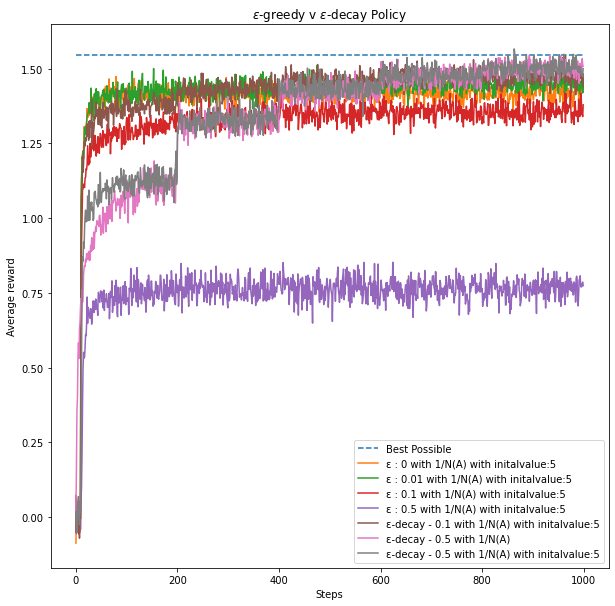

In [ ]:
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot([av_best / runs for _ in range(time)], linestyle="--",label='Best Possible')
plt.plot(average_rewards[0], label='ε : 0 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[1], label='ε : 0.01 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[2], label='ε : 0.1 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[3], label='ε : 0.5 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[4], label='ε-decay - 0.1 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[5], label='ε-decay - 0.5 with 1/N(A)')
plt.plot(average_rewards[6], label='ε-decay - 0.5 with 1/N(A) with initalvalue:5')
plt.title("$\epsilon$-greedy v $\epsilon$-decay Policy")
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show() 

# Step size

In [ ]:
# Hyperparameters
runs = 2000
time = 1000

In [ ]:
# Epsilon decay Policy
bandits = []
bandits.append(Bandit(epsilon=0.01, sample_averages=False , step_size=0.1))
bandits.append(Bandit(epsilon=0.01, sample_averages=False,initial=5, step_size=0.1))
bandits.append(Bandit(epsilon=0.01, sample_averages=False,initial=5 , step_size=0.4))
bandits.append(Bandit(epsilon=0.01, sample_averages=False, initial=5, step_size=0.6))
bandits.append(Bandit(epsilon=0.01, sample_averages=False, initial=5, step_size=0.8))
bandits.append(Bandit(epsilon=0.01, sample_averages=False, initial=5, step_size=1))
bandits.append(Bandit(epsilon=0.5, sample_averages=True, epsilon_decay=True, initial=5))
bandits.append(Bandit(epsilon=0.5, sample_averages=False, epsilon_decay=True, initial=5,step_size=0.1))
_, average_rewards, av_best = simulate(runs, time, bandits)

100%|██████████| 2000/2000 [01:49<00:00, 18.29it/s]


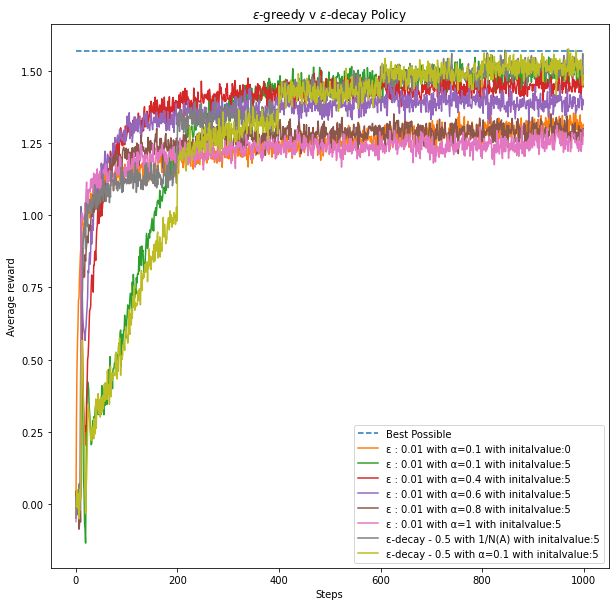

In [ ]:
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot([av_best / runs for _ in range(time)], linestyle="--",label='Best Possible')
plt.plot(average_rewards[0], label='ε : 0.01 with α=0.1 with initalvalue:0')
plt.plot(average_rewards[1], label='ε : 0.01 with α=0.1 with initalvalue:5')
plt.plot(average_rewards[2], label='ε : 0.01 with α=0.4 with initalvalue:5')
plt.plot(average_rewards[3], label='ε : 0.01 with α=0.6 with initalvalue:5')
plt.plot(average_rewards[4], label='ε : 0.01 with α=0.8 with initalvalue:5')
plt.plot(average_rewards[5], label='ε : 0.01 with α=1 with initalvalue:5')
plt.plot(average_rewards[6], label='ε-decay - 0.5 with 1/N(A) with initalvalue:5')
plt.plot(average_rewards[7], label='ε-decay - 0.5 with α=0.1 with initalvalue:5')
plt.title("$\epsilon$-greedy v $\epsilon$-decay Policy")
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show() 